# **Project CS715 - Handling Irregular Time Gaps in Financial Tick Data Using CRU Models:**

## **Setup & Imports:**

In [35]:
!pip install kagglehub --quiet


In [36]:
import os
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam


## **1. Download & Load the Binance BTCUSDT Tick Dataset:**

In [37]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("khanh314/btcusdt-perpetual-future-all-transactions")
print("Dataset downloaded to:", path)

# List files and pick the first CSV
csv_files = glob.glob(os.path.join(path, "*.csv"))
print("CSV files:", csv_files)

file_path = csv_files[0]
print("Using file:", file_path)

# Load into DataFrame
df = pd.read_csv(file_path)
df.head()


Using Colab cache for faster access to the 'btcusdt-perpetual-future-all-transactions' dataset.
Dataset downloaded to: /kaggle/input/btcusdt-perpetual-future-all-transactions
CSV files: ['/kaggle/input/btcusdt-perpetual-future-all-transactions/BTCUSDT-future.csv']
Using file: /kaggle/input/btcusdt-perpetual-future-all-transactions/BTCUSDT-future.csv


,trade_id,time,size,price,side
0,524677801,1.621756e+12,0.026,36232.34,sell
1,524677802,1.621756e+12,0.041,36232.34,sell
2,524677803,1.621756e+12,0.045,36232.35,buy
3,524677804,1.621756e+12,0.001,36232.34,sell
4,524677805,1.621756e+12,0.304,36232.35,buy


## **2. Basic Preprocessing:**

In [38]:
# Keep only needed columns
df = df[['time', 'price', 'size', 'side']].copy()

# Sort by time
df = df.sort_values('time').reset_index(drop=True)

# Convert time to seconds and compute raw dt
df['time_sec'] = df['time'] / 1000.0
df['dt'] = df['time_sec'].diff().fillna(0.0)

# Encode side: buy=1, sell=0
df['side_enc'] = (df['side'] == 'buy').astype(float)

# Next price and label: 1 if next price up, else 0
df['next_price'] = df['price'].shift(-1)
df = df.iloc[:-1].copy()   # drop last row (no next_price)
df['y'] = (df['next_price'] > df['price']).astype(int)

df.head()


,time,price,size,side,time_sec,dt,side_enc,next_price,y
0,1.621756e+12,36232.34,0.026,sell,1.621756e+09,0.000,0.0,36232.34,0
1,1.621756e+12,36232.34,0.041,sell,1.621756e+09,0.122,0.0,36232.35,1
2,1.621756e+12,36232.35,0.045,buy,1.621756e+09,0.077,1.0,36232.34,0
3,1.621756e+12,36232.34,0.001,sell,1.621756e+09,0.020,0.0,36232.35,1
4,1.621756e+12,36232.35,0.304,buy,1.621756e+09,0.007,1.0,36232.34,0


## **3. Use a Subset for Faster Experiments:**

In [ ]:
N = 200_000   # try 200k first; 
df_sub = df.iloc[:N].copy()
len(df_sub)


200000

## **4. Scale & Clip dt for Stable CRU Dynamics:**

### *We clip dt at the 95th percentile and scale to [0,1].*

In [40]:
dt_values = df_sub['dt'].values
dt_95 = np.percentile(dt_values, 95)
print("95th percentile of dt (seconds):", dt_95)

df_sub['dt_clipped'] = np.clip(df_sub['dt'], 0.0, dt_95)
df_sub['dt_scaled'] = df_sub['dt_clipped'] / dt_95

time_gap_col = 'dt_scaled'


95th percentile of dt (seconds): 0.0559999942779541


## **5. Build Feature Arrays X, dt, y & Standardize:**

In [41]:
feature_cols = ['price', 'size', 'side_enc']
label_col = 'y'

X = df_sub[feature_cols].values.astype(np.float32)
dt = df_sub[time_gap_col].values.astype(np.float32)
y = df_sub[label_col].values.astype(np.int64)

# Scale price & size for better training
scaler = StandardScaler()
X[:, :2] = scaler.fit_transform(X[:, :2])

X.shape, dt.shape, y.shape


((200000, 3), (200000,), (200000,))

## **6. Create Sliding Sequences for RNN Input:**

In [42]:
SEQ_LEN = 50  # window length (trades per sequence)

def create_sequences(X, dt, y, seq_len):
    X_seqs, dt_seqs, y_seqs = [], [], []
    for i in range(seq_len, len(X) - 1):
        X_seqs.append(X[i-seq_len:i])
        dt_seqs.append(dt[i-seq_len:i])
        y_seqs.append(y[i+1])  # label = next trade after the window
    return np.stack(X_seqs), np.stack(dt_seqs), np.array(y_seqs)

X_seqs, dt_seqs, y_seqs = create_sequences(X, dt, y, SEQ_LEN)
X_seqs.shape, dt_seqs.shape, y_seqs.shape


((199949, 50, 3), (199949, 50), (199949,))

## **7. Train / Validation Split (Chronological):**

In [43]:
num_samples = X_seqs.shape[0]
train_size = int(0.8 * num_samples)

X_train, X_val = X_seqs[:train_size], X_seqs[train_size:]
dt_train, dt_val = dt_seqs[:train_size], dt_seqs[train_size:]
y_train, y_val = y_seqs[:train_size], y_seqs[train_size:]

X_train.shape, X_val.shape, dt_train.shape, y_train.shape


((159959, 50, 3), (39990, 50, 3), (159959, 50), (159959,))

## **8. PyTorch Dataset & DataLoader:**

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [45]:
class TickDataset(Dataset):
    def __init__(self, X, dt, y):
        self.X = torch.from_numpy(X)       # (N, T, F)
        self.dt = torch.from_numpy(dt)     # (N, T)
        self.y = torch.from_numpy(y)       # (N,)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.dt[idx], self.y[idx]

BATCH_SIZE = 256

train_dataset = TickDataset(X_train, dt_train, y_train)
val_dataset   = TickDataset(X_val, dt_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


## **9. GRU Baseline Model:**

### *9.1 Define GRU Model*

In [46]:
input_dim = X_train.shape[-1]   # (price, size, side_enc)
hidden_dim_gru = 64
num_layers_gru = 1

class GRUBaseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)  # binary classification

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.gru(x)          # out: (B, T, H)
        last_hidden = out[:, -1, :]   # (B, H)
        logits = self.fc(last_hidden).squeeze(-1)  # (B,)
        return logits

model_gru = GRUBaseline(input_dim=input_dim, hidden_dim=hidden_dim_gru, num_layers=num_layers_gru).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_gru = Adam(model_gru.parameters(), lr=1e-3)

model_gru


GRUBaseline(
  (gru): GRU(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

### *9.2 GRU Train & Eval Functions*

In [47]:
def train_one_epoch_gru(model, loader, optimizer):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for X_batch, dt_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        logits = model(X_batch)  # (B,)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(logits) > 0.5).long()
        total_correct += (preds == y_batch.long()).sum().item()
        total_samples += X_batch.size(0)

    return total_loss / total_samples, total_correct / total_samples


def eval_gru(model, loader):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, dt_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            total_correct += (preds == y_batch.long()).sum().item()
            total_samples += X_batch.size(0)

    return total_loss / total_samples, total_correct / total_samples


### *9.3 Train GRU with Best Checkpoint*

In [48]:
EPOCHS_GRU = 20

best_val_loss_gru = float('inf')
best_val_acc_gru = 0.0
best_state_gru = None

for epoch in range(1, EPOCHS_GRU + 1):
    train_loss, train_acc = train_one_epoch_gru(model_gru, train_loader, optimizer_gru)
    val_loss, val_acc = eval_gru(model_gru, val_loader)

    print(f"[GRU] Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_val_loss_gru:
        best_val_loss_gru = val_loss
        best_val_acc_gru = val_acc
        best_state_gru = model_gru.state_dict().copy()

print("\nBest GRU validation:")
print(f"  val_loss={best_val_loss_gru:.4f}, val_acc={best_val_acc_gru:.4f}")

if best_state_gru is not None:
    model_gru.load_state_dict(best_state_gru)


[GRU] Epoch 01: train_loss=0.6923, train_acc=0.5190 | val_loss=0.6918, val_acc=0.5239
[GRU] Epoch 02: train_loss=0.6921, train_acc=0.5220 | val_loss=0.6917, val_acc=0.5232
[GRU] Epoch 03: train_loss=0.6920, train_acc=0.5214 | val_loss=0.6924, val_acc=0.5186
[GRU] Epoch 04: train_loss=0.6918, train_acc=0.5232 | val_loss=0.6927, val_acc=0.5132
[GRU] Epoch 05: train_loss=0.6918, train_acc=0.5222 | val_loss=0.6920, val_acc=0.5203
[GRU] Epoch 06: train_loss=0.6918, train_acc=0.5225 | val_loss=0.6920, val_acc=0.5191
[GRU] Epoch 07: train_loss=0.6917, train_acc=0.5223 | val_loss=0.6922, val_acc=0.5168
[GRU] Epoch 08: train_loss=0.6916, train_acc=0.5234 | val_loss=0.6924, val_acc=0.5167
[GRU] Epoch 09: train_loss=0.6915, train_acc=0.5237 | val_loss=0.6920, val_acc=0.5187
[GRU] Epoch 10: train_loss=0.6914, train_acc=0.5223 | val_loss=0.6920, val_acc=0.5178
[GRU] Epoch 11: train_loss=0.6914, train_acc=0.5238 | val_loss=0.6922, val_acc=0.5192
[GRU] Epoch 12: train_loss=0.6912, train_acc=0.5242 | 

## **10. Tuned CRU Model (Continuous-Time RNN):**
### *10.1 Continuous GRU Cell Using Scaled dt*

In [ ]:
class ContinuousGRUCell(nn.Module):
    """
    Tuned CRU cell with softened decay (time_scale).
    """
    def __init__(self, input_dim, hidden_dim, time_scale=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim)
        self.log_decay = nn.Parameter(torch.zeros(hidden_dim))
        self.time_scale = time_scale    

    def forward(self, x_t, dt_t, h_prev):
        B = x_t.size(0)
        if h_prev is None:
            h_prev = torch.zeros(B, self.hidden_dim, device=x_t.device)

        decay_rate = F.softplus(self.log_decay) + 1e-5

        # scaled dt in [0,1], soften it
        dt_clamped = torch.clamp(dt_t, 0.0, 1.0)
        dt_effective = dt_clamped * self.time_scale      

        dt_expanded = dt_effective.unsqueeze(-1)         # (B,1)

        decay = torch.exp(-dt_expanded * decay_rate)
        h_prior = h_prev * decay

        h_t = self.gru_cell(x_t, h_prior)
        return h_t


### *10.2 CRU Model with Dropout*

In [50]:
class CRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2, time_scale=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell = ContinuousGRUCell(input_dim, hidden_dim, time_scale=time_scale)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, dt):
        B, T, F = x.size()
        h = torch.zeros(B, self.hidden_dim, device=x.device)
        for t in range(T):
            h = self.cell(x[:,t,:], dt[:,t], h)
        h = self.dropout(h)
        return self.fc(h).squeeze(-1)


In [51]:
model_cru = CRUModel(
    input_dim=input_dim,
    hidden_dim=hidden_dim_gru,
    dropout=0.2,
    time_scale=0.5
).to(device)

In [52]:
optimizer_cru = Adam(model_cru.parameters(), lr=1e-3)


### *10.3 CRU Train & Eval Functions*

In [53]:
def train_one_epoch_cru(model, loader, optimizer):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for X_batch, dt_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        dt_batch = dt_batch.to(device)
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        logits = model(X_batch, dt_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(logits) > 0.5).long()
        total_correct += (preds == y_batch.long()).sum().item()
        total_samples += X_batch.size(0)

    return total_loss / total_samples, total_correct / total_samples


def eval_cru(model, loader):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, dt_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            dt_batch = dt_batch.to(device)
            y_batch = y_batch.float().to(device)

            logits = model(X_batch, dt_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            total_correct += (preds == y_batch.long()).sum().item()
            total_samples += X_batch.size(0)

    return total_loss / total_samples, total_correct / total_samples


### *10.4 Train CRU with Best Checkpoint*

In [54]:
EPOCHS_CRU = 20

best_val_loss_cru = float('inf')
best_val_acc_cru = 0.0
best_state_cru = None

for epoch in range(1, EPOCHS_CRU + 1):
    train_loss, train_acc = train_one_epoch_cru(model_cru, train_loader, optimizer_cru)
    val_loss, val_acc = eval_cru(model_cru, val_loader)

    print(f"[CRU] Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_val_loss_cru:
        best_val_loss_cru = val_loss
        best_val_acc_cru = val_acc
        best_state_cru = model_cru.state_dict().copy()

print("\nBest CRU validation:")
print(f"  val_loss={best_val_loss_cru:.4f}, val_acc={best_val_acc_cru:.4f}")

if best_state_cru is not None:
    model_cru.load_state_dict(best_state_cru)


[CRU] Epoch 01: train_loss=0.6925, train_acc=0.5181 | val_loss=0.6922, val_acc=0.5234
[CRU] Epoch 02: train_loss=0.6922, train_acc=0.5222 | val_loss=0.6919, val_acc=0.5260
[CRU] Epoch 03: train_loss=0.6920, train_acc=0.5212 | val_loss=0.6920, val_acc=0.5198
[CRU] Epoch 04: train_loss=0.6919, train_acc=0.5226 | val_loss=0.6921, val_acc=0.5237
[CRU] Epoch 05: train_loss=0.6919, train_acc=0.5227 | val_loss=0.6921, val_acc=0.5181
[CRU] Epoch 06: train_loss=0.6918, train_acc=0.5231 | val_loss=0.6919, val_acc=0.5218
[CRU] Epoch 07: train_loss=0.6916, train_acc=0.5233 | val_loss=0.6915, val_acc=0.5252
[CRU] Epoch 08: train_loss=0.6915, train_acc=0.5247 | val_loss=0.6915, val_acc=0.5252
[CRU] Epoch 09: train_loss=0.6913, train_acc=0.5250 | val_loss=0.6925, val_acc=0.5174
[CRU] Epoch 10: train_loss=0.6911, train_acc=0.5272 | val_loss=0.6912, val_acc=0.5255
[CRU] Epoch 11: train_loss=0.6910, train_acc=0.5258 | val_loss=0.6915, val_acc=0.5238
[CRU] Epoch 12: train_loss=0.6908, train_acc=0.5272 | 

## **11. Final Comparison: GRU vs Tuned CRU:**

In [55]:
gru_val_loss, gru_val_acc = eval_gru(model_gru, val_loader)
cru_val_loss, cru_val_acc = eval_cru(model_cru, val_loader)

print("\n" + "="*50)
print("      MODEL COMPARISON SUMMARY (TUNED)")
print("="*50)
print(f"GRU Baseline:")
print(f"  Validation Accuracy: {gru_val_acc:.4f}")
print(f"  Validation Loss:     {gru_val_loss:.4f}")
print("-"*50)
print(f"CRU (Tuned):")
print(f"  Validation Accuracy: {cru_val_acc:.4f}")
print(f"  Validation Loss:     {cru_val_loss:.4f}")
print("="*50)

if cru_val_acc > gru_val_acc:
    print("🔥 Tuned CRU now outperforms GRU!")
elif gru_val_acc > cru_val_acc:
    print("⚠️ GRU still has slightly higher accuracy, but compare log-loss too.")
else:
    print("➖ Same accuracy; check ROC-AUC, log-loss, and dt-stratified performance.")



      MODEL COMPARISON SUMMARY (TUNED)
GRU Baseline:
  Validation Accuracy: 0.5207
  Validation Loss:     0.6925
--------------------------------------------------
CRU (Tuned):
  Validation Accuracy: 0.5239
  Validation Loss:     0.6914
🔥 Tuned CRU now outperforms GRU!


## **STEP 1 — Helper: collect predictions**

In [56]:
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score,
    brier_score_loss
)
import matplotlib.pyplot as plt
import numpy as np


### **Collect all predictions from GRU:**

In [57]:
def get_predictions_gru(model, loader):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for Xb, dtb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.numpy()

            logits = model(Xb)
            p = torch.sigmoid(logits).cpu().numpy()

            probs.extend(p)
            preds.extend((p > 0.5).astype(int))
            labels.extend(yb)

    return np.array(preds), np.array(probs), np.array(labels)

gru_preds, gru_probs, gru_labels = get_predictions_gru(model_gru, val_loader)


### **Collect all predictions from CRU**

In [58]:
def get_predictions_cru(model, loader):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for Xb, dtb, yb in loader:
            Xb = Xb.to(device)
            dtb = dtb.to(device)
            yb = yb.numpy()

            logits = model(Xb, dtb)
            p = torch.sigmoid(logits).cpu().numpy()

            probs.extend(p)
            preds.extend((p > 0.5).astype(int))
            labels.extend(yb)

    return np.array(preds), np.array(probs), np.array(labels)

cru_preds, cru_probs, cru_labels = get_predictions_cru(model_cru, val_loader)


## **STEP 2 — Compute Full Metrics (AUC, F1, Precision, Recall)**

In [59]:
def print_metrics(name, preds, probs, labels):
    print("\n============================")
    print(f"   {name} METRICS")
    print("============================")
    print("Accuracy: ", (preds == labels).mean())
    print("Precision:", precision_score(labels, preds))
    print("Recall:   ", recall_score(labels, preds))
    print("F1 Score: ", f1_score(labels, preds))
    print("AUC:      ", roc_auc_score(labels, probs))
    print("Brier:    ", brier_score_loss(labels, probs))

print_metrics("GRU", gru_preds, gru_probs, gru_labels)
print_metrics("CRU", cru_preds, cru_probs, cru_labels)



   GRU METRICS
Accuracy:  0.5206801700425107
Precision: 0.5170138888888889
Recall:    0.30449897750511246
F1 Score:  0.3832689832689833
AUC:       0.5237707226631513
Brier:     0.24968094883181519

   CRU METRICS
Accuracy:  0.5239309827456864
Precision: 0.5183003786285233
Recall:    0.37791411042944784
F1 Score:  0.4371119389746319
AUC:       0.5324501127096666
Brier:     0.24910871734491208


## **STEP 3 — Confusion Matrix**

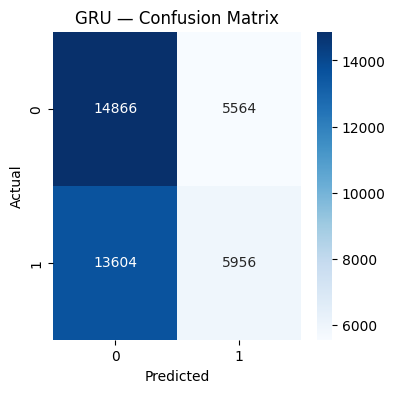

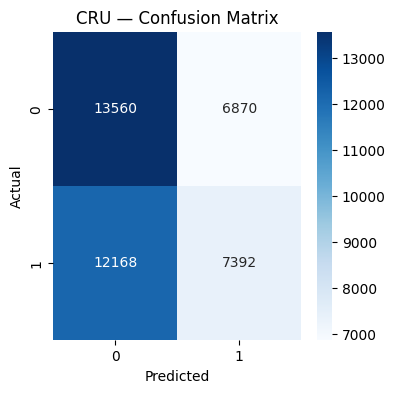

In [60]:
import seaborn as sns

def plot_confusion_matrix(name, preds, labels):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix("GRU", gru_preds, gru_labels)
plot_confusion_matrix("CRU", cru_preds, cru_labels)


## **STEP 4 — ROC Curve**

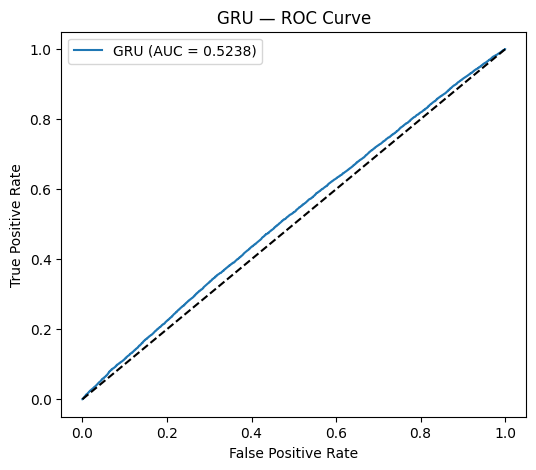

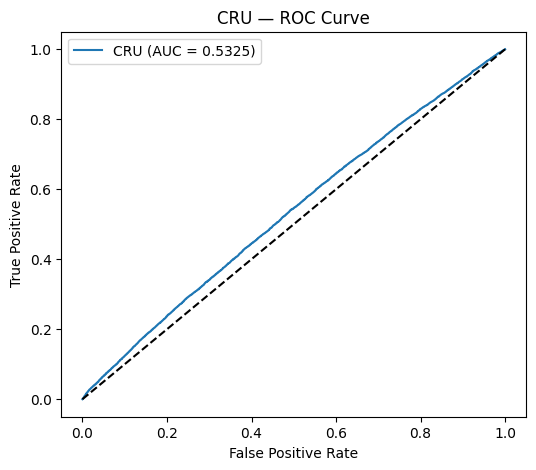

In [61]:
def plot_roc_curve(name, labels, probs):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = roc_auc_score(labels, probs)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} — ROC Curve")
    plt.legend()
    plt.show()

plot_roc_curve("GRU", gru_labels, gru_probs)
plot_roc_curve("CRU", cru_labels, cru_probs)


## **STEP 5 — Calibration Curve**

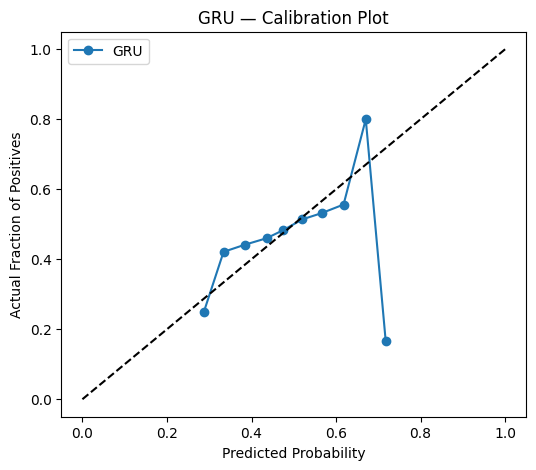

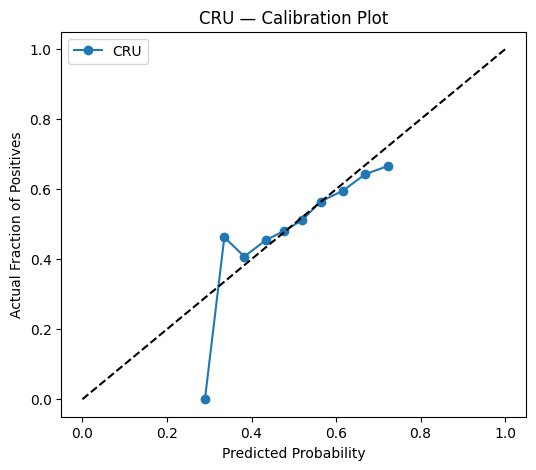

In [62]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(name, labels, probs):
    frac_pos, mean_pred = calibration_curve(labels, probs, n_bins=20)

    plt.figure(figsize=(6,5))
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"{name} — Calibration Plot")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Fraction of Positives")
    plt.legend()
    plt.show()

plot_calibration_curve("GRU", gru_labels, gru_probs)
plot_calibration_curve("CRU", cru_labels, cru_probs)


## **Plot PR Curve for GRU & CRU**

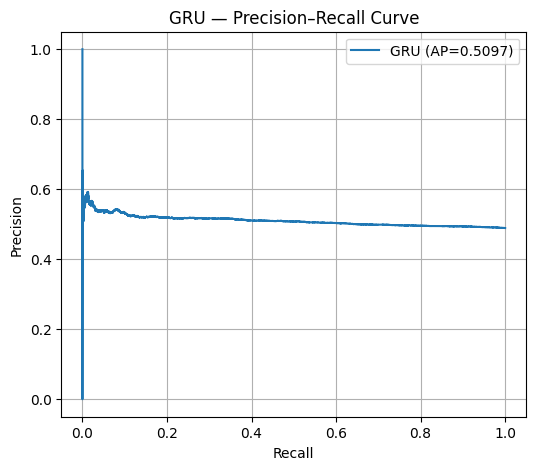

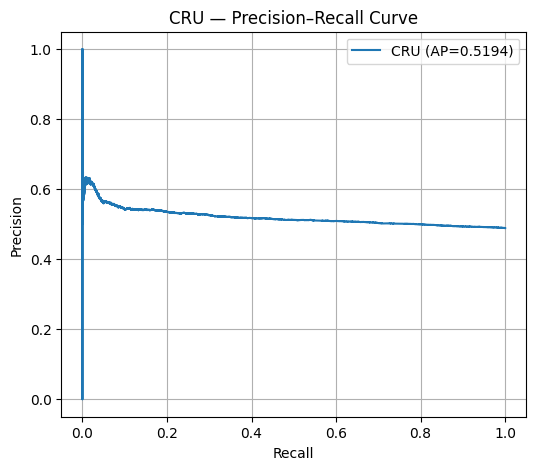

In [63]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_pr_curve(name, labels, probs):
    precision, recall, _ = precision_recall_curve(labels, probs)
    ap = average_precision_score(labels, probs)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"{name} (AP={ap:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} — Precision–Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pr_curve("GRU", gru_labels, gru_probs)
plot_pr_curve("CRU", cru_labels, cru_probs)


## **Threshold Sweep Analysis (Find Best Threshold for CRU)**

In [64]:
def find_best_threshold(probs, labels):
    best_thr = 0.5
    best_f1 = 0
    best_acc = 0

    for thr in np.linspace(0.1, 0.9, 81):  # step size 0.01
        preds = (probs >= thr).astype(int)
        f1 = f1_score(labels, preds)
        acc = (preds == labels).mean()

        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
            best_acc = acc

    return best_thr, best_f1, best_acc

best_thr, best_f1, best_acc = find_best_threshold(cru_probs, cru_labels)
print("Best threshold:", best_thr)
print("Best F1:", best_f1)
print("Accuracy at this threshold:", best_acc)


Best threshold: 0.32
Best F1: 0.6569485263246284
Accuracy at this threshold: 0.4891972993248312


## **Plot F1 vs Threshold Curve**

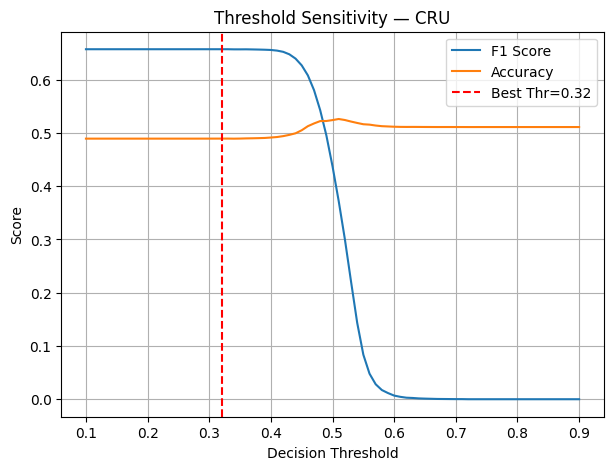

In [65]:
def plot_threshold_curve(probs, labels):
    thr_list = np.linspace(0.1, 0.9, 81)
    f1_list = []
    acc_list = []

    for thr in thr_list:
        preds = (probs >= thr).astype(int)
        f1_list.append(f1_score(labels, preds))
        acc_list.append((preds == labels).mean())

    plt.figure(figsize=(7,5))
    plt.plot(thr_list, f1_list, label="F1 Score")
    plt.plot(thr_list, acc_list, label="Accuracy")
    plt.axvline(best_thr, color='red', linestyle='--', label=f"Best Thr={best_thr:.2f}")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Sensitivity — CRU")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_threshold_curve(cru_probs, cru_labels)


## **Statistical Significance Tests**

### *3.1 McNemar Test (GRU vs CRU)*

In [66]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar_test(preds1, preds2, labels):
    # 2x2 table:
    # b = GRU wrong, CRU right
    # c = GRU right, CRU wrong
    b = np.sum((preds1 != labels) & (preds2 == labels))
    c = np.sum((preds1 == labels) & (preds2 != labels))

    table = [[0, b],
             [c, 0]]

    result = mcnemar(table, exact=False, correction=True)
    print("McNemar Test:")
    print("Statistic:", result.statistic)
    print("p-value :", result.pvalue)

# Use predicted labels (threshold 0.5)
run_mcnemar_test(gru_preds, cru_preds, gru_labels)


McNemar Test:
Statistic: 2.3391903289288725
p-value : 0.12615510984036188
